## Training

In [1]:
try:
  import tf_agents
except ImportError:
  %pip install tf-agents
  %pip install tf-keras

2025-07-20 22:26:45.003775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 22:26:45.033652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-20 22:26:45.033673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-20 22:26:45.034820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-20 22:26:45.040100: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.float_format', lambda x: '%.4f' % x)

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from trading_utils import preprocess_data, create_wide_format_data, SYMBOLS
from trading_env import CryptoTradingEnvironment

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Data and Model Paths
DATA_FILEPATH = 'data/ohlcv.csv.gz'
POLICY_SAVE_PATH = 'policy'

# Model Hyperparameters
NUM_TRAINING_STEPS = 2000  # Increased for more meaningful training
NUM_TESTING_STEPS = 500
ALPHA = 1.0 # LinUCB exploration parameter
TEST_SIZE = 0.2
SEED_FUND = 100.0
TRADE_SIZE = 20.0
TRADE_FEE = 0.001
INVALID_ACTION_PENALTY = -1.0

TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']
TECHNICAL_FEATURES = ['price_change', 'rsi', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']

# Load Data
df = pd.read_csv(DATA_FILEPATH, compression='gzip', parse_dates=['timestamp']) #.set_index('timestamp')
all_data = preprocess_data(df) #.iloc[3000:]
observation_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=SYMBOLS, 
    features=TECHNICAL_FEATURES
)

train_observation_df, test_observation_df = train_test_split(
    observation_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

train_prices_df, test_prices_df = train_test_split(
    prices_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

scaler = StandardScaler()
train_observation_scaled_df = pd.DataFrame(scaler.fit_transform(train_observation_df), columns=train_observation_df.columns, index=train_observation_df.index)
test_observation_scaled_df = pd.DataFrame(scaler.transform(test_observation_df), columns=train_observation_df.columns, index=test_observation_df.index)


print(f"all_data: {all_data.shape}")
print(f"observation training data: {train_observation_scaled_df.shape}")
print(f"price training data: {train_prices_df.shape}")
print(f"observation testing data: {test_observation_scaled_df.shape}")
print(f"price testing data: {test_prices_df.shape}")

all_data: (111560, 15)
observation training data: (17849, 30)
price training data: (17849, 5)
observation testing data: (4463, 30)
price testing data: (4463, 5)


In [3]:
# Setup Environment
crypto_env = CryptoTradingEnvironment(
    observation_df=train_observation_scaled_df,
    prices_df=train_prices_df,
    symbols=SYMBOLS,
    seed_fund=SEED_FUND,
    trade_size=TRADE_SIZE,
    trade_fee=TRADE_FEE,
    invalid_action_penalty=INVALID_ACTION_PENALTY,
)

tf_env = tf_py_environment.TFPyEnvironment(crypto_env)

# Setup Agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    alpha=ALPHA,
    dtype=tf.float32
)

class ShowProgress:
    def __init__(self, total, interval=50):
        self.counter = 0
        self.total = total
        self.interval = interval
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % self.interval == 0:
            print("\r{}/{} Reward: {}".format(self.counter, self.total, np.round(trajectory.reward.numpy()[0], 6)), end="")

class MetricsObserver:
    def __init__(self, oracle_fn):
        self._oracle_fn = oracle_fn
        self.rewards = []
        self.regrets = []
        self.optimal_rewards = []

    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            reward = trajectory.reward.numpy()[0]
            optimal_reward = self._oracle_fn(trajectory)
            regret = optimal_reward - reward
            
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.optimal_rewards.append(optimal_reward)

    def cum_rewards(self):
        cumulative_reward = np.cumsum(self.rewards)
        cumulative_optimal_reward = np.cumsum(self.optimal_rewards)
        return cumulative_reward, cumulative_optimal_reward

    def cum_averages(self):
        steps = np.arange(len(self.rewards)) + 1
        cumulative_avg_reward = np.cumsum(self.rewards) / steps
        cumulative_avg_optimal_reward = np.cumsum(self.optimal_rewards) / steps
        cumulative_avg_regret = np.cumsum(self.regrets) / steps
        return cumulative_avg_reward, cumulative_avg_optimal_reward, cumulative_avg_regret
        

def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)
        
metrics_observer = MetricsObserver(tf_env.pyenv.envs[0].optimal_reward_oracle)

# 5. Setup Driver
# Set num_steps to the total number of steps you want to train for.
num_steps_to_train = min(len(train_observation_scaled_df) - 1, NUM_TRAINING_STEPS)

driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    num_steps=num_steps_to_train,
    observers=[train_step, metrics_observer, ShowProgress(num_steps_to_train)]
)

print(f"\nStarting training for {num_steps_to_train} steps...")
driver.run()
print("Training finished.")

# Save Policy
print(f"\nSaving the trained policy to: {POLICY_SAVE_PATH}")
saver = policy_saver.PolicySaver(agent.policy)
saver.save(POLICY_SAVE_PATH)
print("Policy saved successfully.")

2025-07-20 22:26:47.485819: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-20 22:26:47.492309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-20 22:26:47.494721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Starting training for 2000 steps...
2000/2000 Reward: 0.0004419999895617366Training finished.

Saving the trained policy to: policy


INFO:tensorflow:Assets written to: policy/assets


/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/assets


Policy saved successfully.


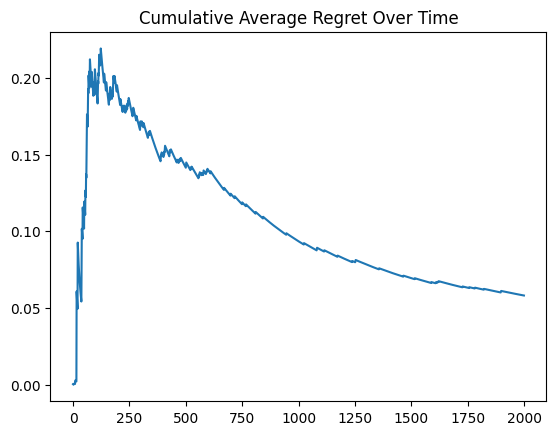

In [4]:
cumulative_avg_reward, cumulative_avg_optimal_reward, cumulative_avg_regret = metrics_observer.cum_averages()

plt.plot(cumulative_avg_regret)
plt.title('Cumulative Average Regret')
plt.show()

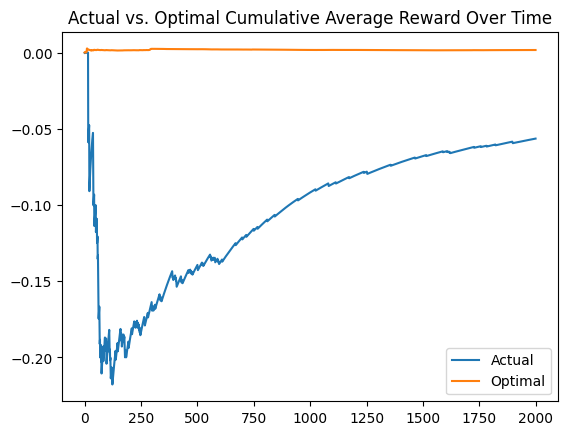

In [5]:
plt.plot(cumulative_avg_reward, label='Actual')
plt.plot(cumulative_avg_optimal_reward, label='Optimal')
plt.title('Actual vs. Optimal Cumulative Average Reward')
plt.legend()
plt.show()

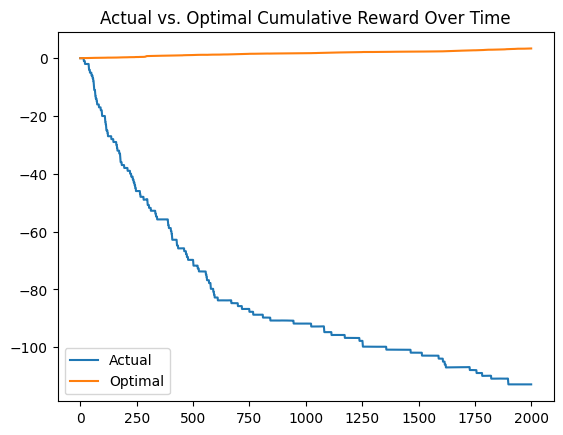

In [6]:
cumulative_reward, cumulative_optimal_reward = metrics_observer.cum_rewards()

plt.plot(cumulative_reward, label='Actual')
plt.plot(cumulative_optimal_reward, label='Optimal')
plt.title('Actual vs. Optimal Cumulative Reward')
plt.legend()
plt.show()

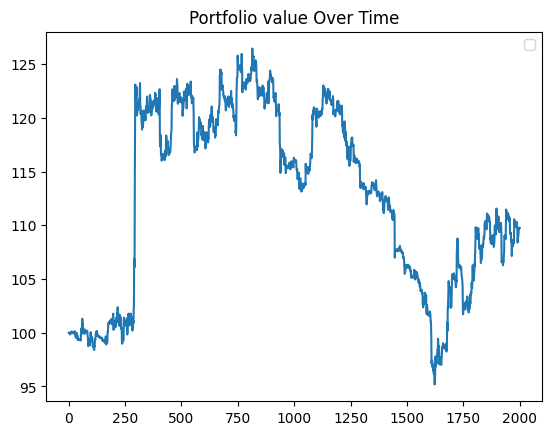

In [7]:
portfolio_value_history = tf_env.pyenv.envs[0].portfolio_value_history

plt.plot(portfolio_value_history)
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

In [8]:
trade_history = tf_env.pyenv.envs[0].trade_history

trade_history_df = pd.DataFrame(trade_history, columns=['Symbol', 'Valid', 'Type', 'Value'])
trade_history_df.head(5)

,Symbol,Valid,Type,Value
0,BTC,1,TradeType.BUY,20.0000
1,BTC,1,TradeType.HOLD,0.0000
2,BTC,1,TradeType.SELL,19.9843
3,DOGE,1,TradeType.BUY,20.0000
4,DOGE,1,TradeType.HOLD,0.0000


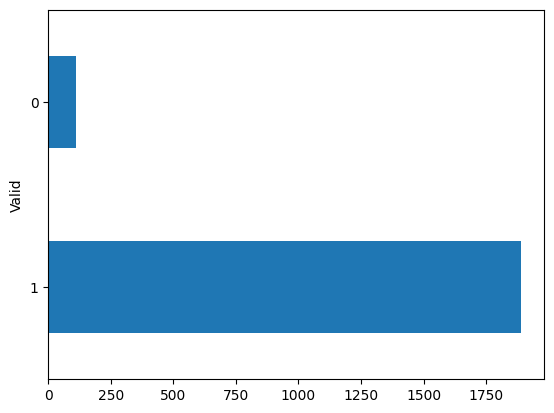

In [9]:
trade_history_df['Valid'].value_counts().plot(kind='barh')
plt.show()

## Evaluation

In [10]:
num_steps_to_test = min(len(test_observation_scaled_df) - 1, NUM_TESTING_STEPS)

eval_env = CryptoTradingEnvironment(
    observation_df=test_observation_scaled_df[:num_steps_to_test],
    prices_df=test_prices_df[:num_steps_to_test],
    symbols=SYMBOLS,
    seed_fund=SEED_FUND,
    trade_size=TRADE_SIZE,
    trade_fee=TRADE_FEE,
    invalid_action_penalty=INVALID_ACTION_PENALTY,
)

# 4. Run the Evaluation Loop
print(f"\n--- Starting Evaluation on Test Set ({len(test_observation_scaled_df)} steps) ---")

time_step = eval_env.reset()

counter = 0

# Loop until the environment signals the episode is over
while not time_step.is_last():
    # The policy expects a batch dimension. We create a new TimeStep
    # object with the observation correctly batched.
    counter += 1
    if counter % 50 == 0:
        print(f"\rTraining step {counter}/{num_steps_to_test}", end="")
    
    # A. Add the batch dimension to the observation tensor.
    observation_batch = tf.expand_dims(time_step.observation, 0)
    
    # B. Use the ._replace() method to create a new TimeStep with the batched observation.
    # This is the correct way to modify a TimeStep.
    batched_time_step = time_step._replace(observation=observation_batch)
    
    # C. Get an action from the loaded policy using the batched TimeStep.
    action_step = agent.policy.action(batched_time_step)
    action = action_step.action.numpy()[0]
    
    # D. Step the environment with the original, unbatched action.
    time_step = eval_env.step(action)

print("\n--- Evaluation Finished ---")


--- Starting Evaluation on Test Set (4463 steps) ---
Training step 450/500
--- Evaluation Finished ---


Initial Portfolio Value: $100.00
Final Portfolio Value:   $86.71
Total Return on Test Set: -13.29%


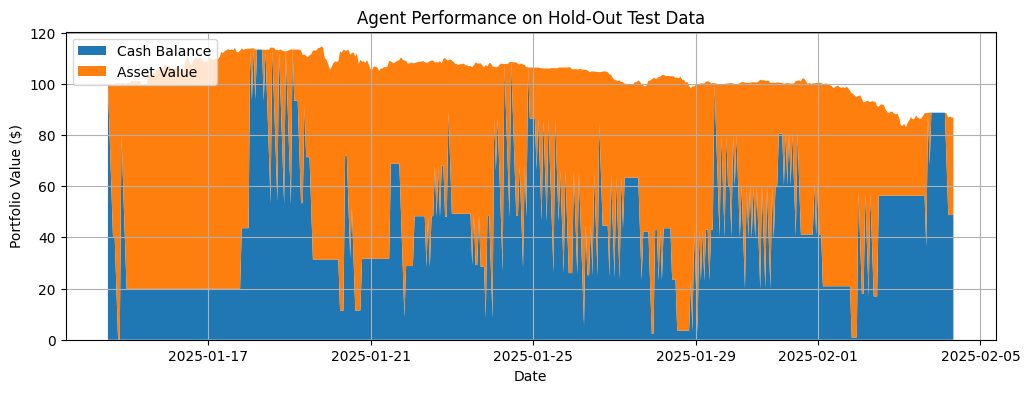

In [11]:
# 5. Report and Plot the Results
balance_history = eval_env.balance_history
asset_value_history = eval_env.asset_value_history
portfolio_value_history = eval_env.portfolio_value_history
seed_fund_value = balance_history[0]
final_portfolio_value = portfolio_value_history[-1]
total_return_pct = ((final_portfolio_value - seed_fund_value) / seed_fund_value) * 100

print(f"Initial Portfolio Value: ${seed_fund_value:,.2f}")
print(f"Final Portfolio Value:   ${final_portfolio_value:,.2f}")
print(f"Total Return on Test Set: {total_return_pct:.2f}%")

# Plot the portfolio value over time
plt.figure(figsize=(12, 4))
plt.stackplot(test_prices_df.index[:len(balance_history)],[balance_history, asset_value_history], labels=['Cash Balance','Asset Value'])
plt.legend(loc='upper left')
plt.title('Agent Performance on Hold-Out Test Data')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()